## Unsustainable water use

The water footprint is an indicator of direct and indirect appropriation of freshwater resources. This term includes both consumptive water use (the blue and green water footprint) and the water required to assimilate pollution (grey water footprint).

Advanced frameworks consider both water performance in the direct operation as well as the indirect water footprint in order to fully understand how a certain business relates to water use efficiency and the exposure to risk.

The indicator provides incentives to improve water use efficiency through all sectors, highlighting those sectors where water use efficiency is lagging behind. 

We derive the total amount of annual, crop-specific water use from the blue water requirements of the Water Footprint Network (WFN) data layer. All calculations are performed on the grid-cell level  which comes in a resolution 5 minutes by 5 minutes (~10 km by 10 km).

Unsustainable water consumption (m3 / year) = blue water footprint (mm / yr) * harvest area portion in that location * tonnes (Tonne)  * 10000/1000 * yield (ha/Tonne)


Potential datasets:

- Global water footprint by crop (1996 -2005) from Water Footprint which is splited by:
    - Blue Footprint by crop
    - Green Footprint by crop
    - Grey Footprint by crop
    - Total Footprint by crop
    
    Link to dataset: "https://waterfootprint.org/media/downloads/Report47-App-IV-CropWaterFootprints-RasterMaps.zip"
    
- BWS from aqueduct: https://www.wri.org/data/aqueduct-global-maps-30-data
- Harvested area and yield for 175 crops: http://www.earthstat.org/harvested-area-yield-175-crops/

### Insights from notebook and generalizations:

The first part of the notebook covers the generation of the water risk map. This water risk map is calculated for each commodity (in this case cotton) and following the formula below (which is also presented in this doc: https://docs.google.com/document/d/1h4BIWMrv6OGRAgNPlOfjOLex_FHb9h22RRTLp00QMzs/edit#

        Water risk  (m3 / year * hectare) =  blue water footprint (mm / yr) * harvest area portion in that location  * 10000/1000(unit conversion)

This calculation has been done with gdal and has to be generalised to the different commodities.

The second part of the notebook explores the generation of the potential distributed purchase area (which sould be updated as it's highlighted in the notebook 0_5_Area_distribution. This calculations have been also done with gdal for the time being.

Finally we calculate the water metric by multiplying the water risk map and the potential distributed purchase area, following the formula: 

        Unsustainable water consumption (m3 / year) = risk map (m3/year*hectare) * probability purchase area (Hectare) 
        
 NOTE: Both the water risk map and the potential distributed purchase area will need to be translater to h3. The final calculation (the calculation of the metric) would be done by combining the indexes of both h3 layers.


### Import libraries:

In [14]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import rasterio as rio
import rasterio.plot
import matplotlib.pyplot as plt
from rasterio.plot import show_hist
import time
from rasterstats import gen_zonal_stats, gen_point_query
from shapely.geometry import shape, mapping
import folium
from rasterstats import gen_zonal_stats, gen_point_query
import h3

In [2]:
from processing.geolocating_data import GeolocateAddress

### Calculation of Unsustainable water consumption: 
    
Unsustainable water consumption (m3 / year) = blue water footprint (mm / yr) * harvest area portion in that location * tonnes (Tonne)  * 10000/1000 * yield (ha/Tonne)

Where:
- Blue water footprint (mm/yr) is the data provided by the WFN. This data has been calculated by dividing the total water footprint per grid cell (m3/yr) by the total area of the grid-cell. Therefore, we will need to re-scale this to the harvested area of the crop of interest (fraction of grid cell which is cultivated with the crop of interest.
- Harvest area portion in that location is obtained from EarthStat.
- The division by 1000 coverst the mm to m3 and the multiplication by 10000 to ha.
- Tonnes would be the volume purchased in a location
- Yield (ha/tonnes) for a specific crop is obtained from EarthStat


### Calculation of risk map - impact factor for different locations: 

The calculation of the risk map would be done following the process highlighted in this document: https://docs.google.com/document/d/1h4BIWMrv6OGRAgNPlOfjOLex_FHb9h22RRTLp00QMzs/edit#

The formula used to compute the risk map is:

 Water risk  (m3 / year * Tonnes) =  blue water footprint (mm / yr) * harvest area portion in that location  * yield (ha/Tonne) * 10000/1000(unit conversion)


and the datasets used are:

- Blue water footprint for each commodity
- Harvest area portion 
- yield
- conversion units



In [5]:
blwf_path = '../../datasets/raw/wfbl_mmyr_4326_cotton.tif'
ha_fraction_path = '../../datasets/raw/cotton_HarvestedAreaFraction.tif'
yield_path = '../../datasets/raw/cotton_YieldPerHectare.tif'

### 1. Check raster info:

In [7]:
#explore datasets info for calculation - the three raster need to have the same extent and projection
!gdalinfo '../../datasets/raw/wfbl_mmyr_4326_cotton.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/wfbl_mmyr_4326_cotton.tif
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.991666650000013,83.088333349999999)
Pixel Size = (0.083333333333333,-0.083333333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-179.9916667,  83.0883333) (179d59'30.00"W, 83d 5'18.00"N)
Lower Left  (-179.9916667, -55.9116667) (179d59'30.00"W, 55d54'42.00"S)
Up

In [8]:
!gdalinfo '../../datasets/raw/cotton_HarvestedAreaFraction.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/cotton_HarvestedAreaFraction.tif
Size is 4320, 2160
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,89.999999999989768)
Pixel Size = (0.083333333333329,-0.083333333333329)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_SOFTWARE=MATLAB 8.0, Mapping Toolbox 3.6
Image Structure Metadata:
  COMPRESSION=PACKBITS
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-180.0000000,  90.0000000) (180d 0' 0.00"W, 90d 0' 0

In [9]:
!gdalinfo '../../datasets/raw/cotton_YieldPerHectare.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/cotton_YieldPerHectare.tif
Size is 4320, 2160
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,89.999999999989768)
Pixel Size = (0.083333333333329,-0.083333333333329)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_SOFTWARE=MATLAB 8.0, Mapping Toolbox 3.6
Image Structure Metadata:
  COMPRESSION=PACKBITS
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-180.0000000,  90.0000000) (180d 0' 0.00"W, 90d 0' 0.00"N)

### 2. Extent:
The three rasters have the same projection but the blue water footprint has different extent. Therefore we need to get the rasters into the same extent.


In [10]:
## projwin: upper left and lower right of the raster that we want to use  for clipping the other rasters
## -of GTiff: geotiff we want to clip - change extent
!gdal_translate -projwin -179.99166665 83.08833335 180.00833335 -55.91166665 -of GTiff '../../datasets/raw/cotton_HarvestedAreaFraction.tif' '../../datasets/raw/cotton_HarvestedAreaFraction_extent.tif'

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [11]:
## projwin: upper left and lower right of the raster that we want to use  for clipping the other rasters
## -of GTiff: geotiff we want to clip - change extent
!gdal_translate -projwin -179.99166665 83.08833335 180.00833335 -55.91166665 -of GTiff '../../datasets/raw/cotton_YieldPerHectare.tif' '../../datasets/raw/cotton_YieldPerHectare_extent.tif'

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


### 3. Calculate risk 

In [12]:
!gdal_calc.py -A '../../datasets/raw/wfbl_mmyr_4326_cotton.tif' -B '../../datasets/raw/cotton_HarvestedAreaFraction_extent.tif' -C '../../datasets/raw/cotton_YieldPerHectare_extent.tif' --outfile='../../datasets/processed/water_risk_cotton_gdal_4326.tif' --calc="A*B*C*(10000/1000)"

<string>:1: RuntimeWarning: overflow encountered in multiply
/opt/conda/lib/python3.8/site-packages/osgeo/utils/gdal_calc.py:367: RuntimeWarning: invalid value encountered in multiply
  myResult = ((1 * (myNDVs == 0)) * myResult) + (myOutNDV * myNDVs)
0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 

### 4. Explore output:

In [13]:
!gdalinfo '../../datasets/processed/water_risk_cotton_gdal_4326.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/water_risk_cotton_gdal_4326.tif
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.991666650000013,83.088333349999999)
Pixel Size = (0.083333333333333,-0.083333333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-179.9916667,  83.0883333) (179d59'30.00"W, 83d 5'18.00"N)
Lower Left  (-179.9916667, -55.9116667) (179d59'30.00"W, 55d54

In [14]:
!gdalinfo -stats -hist '../../datasets/processed/water_risk_cotton_gdal_4326.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/water_risk_cotton_gdal_4326.tif
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.991666650000013,83.088333349999999)
Pixel Size = (0.083333333333333,-0.083333333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-179.9916667,  83.0883333) (179d59'30.00"W, 83d 5'18.00"N)
Lower Left  (-179.9916667, -55.9116667) (179d59'30.00"W, 55d54

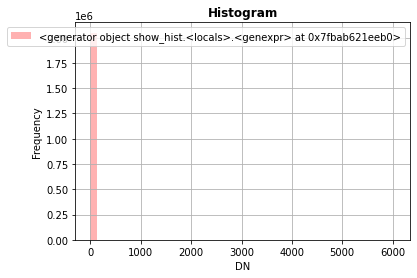

In [18]:
## plot histogram of calculated water risk map with no null values

src = rio.open('../../datasets/processed/water_risk_cotton_gdal_4326.tif')
show_hist(
    src, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")

### 4. Reproject raster from epsg:4326 to epsg:3857

Reproject raster from 4326 to 3857 as the hexgrid is in that projection. We can do it the other way around by reprojecting the vector layer from epsg:3857 to epsg:4326.

In [19]:
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -r near -of GTiff '../../datasets/processed/water_risk_cotton_gdal_4326.tif' '../../datasets/processed/water_risk_cotton_gdal_3857.tif'

Creating output file that is 3909P x 2482L.
Processing ../../datasets/processed/water_risk_cotton_gdal_4326.tif [1/1] : 0Using internal nodata values (e.g. 3.40282e+38) for image ../../datasets/processed/water_risk_cotton_gdal_4326.tif.
Copying nodata values from source ../../datasets/processed/water_risk_cotton_gdal_4326.tif to destination ../../datasets/processed/water_risk_cotton_gdal_3857.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [20]:
!gdalinfo -stats -hist '../../datasets/processed/water_risk_cotton_gdal_3857.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/water_risk_cotton_gdal_3857.tif
Size is 3909, 2482
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],
        PARAMETER["Latitud

### Remove null values and compute histogram

In [21]:
##RASTER/(RASTER>0)
!gdal_calc.py -A '../../datasets/processed/water_risk_cotton_gdal_3857.tif' --outfile='../../datasets/processed/water_risk_cotton_gdal_3857_noZeros.tif' --calc="A/(A>0)"

<string>:1: RuntimeWarning: invalid value encountered in true_divide
0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9..

In [23]:
!gdalinfo -stats -hist '../../datasets/processed/water_risk_cotton_gdal_3857_noZeros.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/water_risk_cotton_gdal_3857_noZeros.tif
Size is 3909, 2482
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],
        PARAMETER[

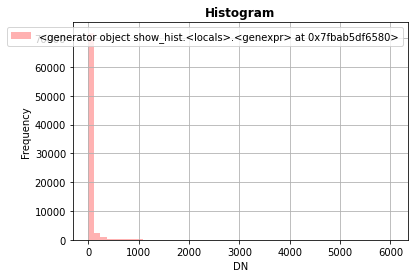

In [22]:
## plot histogram of calculated water risk map with no null values

src = rio.open('../../datasets/processed/water_risk_cotton_gdal_3857_noZeros.tif')
show_hist(
    src, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")

#### Zonal statistics with the raster values and the hexgrid
In the prototype I'm going to use hexgrid intead og h3 in order to simplify things.

In [3]:
#import vector hexgrid for india - note: this would be worldwide but for computational limitations I use indi as test
ind_hexgrid = gpd.read_file('../../datasets/raw/gadm_36_india_hexgrid.shp')
ind_hexgrid.head()

,fid,id,left,top,right,bottom,geometry
0,36916221.0,36916221.0,8.122601e+06,9.254847e+05,8.129059e+06,9.198919e+05,"POLYGON ((8122600.657 922688.319, 8124215.157 ..."
1,36922569.0,36922569.0,8.127444e+06,9.282811e+05,8.133902e+06,9.226883e+05,"POLYGON ((8127444.157 925484.715, 8129058.657 ..."
2,36928918.0,36928918.0,8.132288e+06,9.310775e+05,8.138746e+06,9.254847e+05,"POLYGON ((8132287.657 928281.111, 8133902.157 ..."
3,36814601.0,36814601.0,8.045105e+06,1.126825e+06,8.051563e+06,1.121232e+06,"POLYGON ((8045104.657 1124028.833, 8046719.157..."
4,36820948.0,36820948.0,8.049948e+06,1.135214e+06,8.056406e+06,1.129622e+06,"POLYGON ((8049948.157 1132418.021, 8051562.657..."


In [11]:
#summary statistics in test geometry - adm level 3
start_time = time.time()
raster_path = '../../datasets/processed/water_risk_cotton_gdal_3857_noZeros.tif'
wr_stats_hexgrid = gen_zonal_stats(
    ind_hexgrid,
    raster_path,
    stats="median std",
    prefix = 'wr_',
    geojson_out=True,
    all_touched=True
    )
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00014662742614746094 seconds ---


In [12]:

for feature in wr_stats_hexgrid:
    print(feature)
    break

{'id': '0', 'type': 'Feature', 'properties': {'bottom': 919891.9226220362, 'fid': 36916221.0, 'id': 36916221.0, 'left': 8122600.657196499, 'right': 8129058.657196496, 'top': 925484.7146796733, 'wr_median': None, 'wr_std': None}, 'geometry': {'type': 'Polygon', 'coordinates': (((8122600.657196499, 922688.3186508566), (8124215.1571964985, 925484.7146796733), (8127444.157196497, 925484.7146796733), (8129058.657196496, 922688.3186508566), (8127444.157196497, 919891.9226220362), (8124215.1571964985, 919891.9226220362), (8122600.657196499, 922688.3186508566)),)}, 'bbox': (8122600.657196499, 919891.9226220362, 8129058.657196496, 925484.7146796733)}


In [13]:
#generate a dataframe with the elements
start_time = time.time()
h3_wr_cotton = pd.DataFrame([],columns=['h3_id', 'wr_cotton_median', 'geometry'])
for feature in wr_stats_hexgrid:
    h3_wr_cotton.loc[len(h3_wr_cotton)]=[
        feature['properties']['fid'],
        feature['properties']['wr_median'],
        shape(feature['geometry'])
            ]
print("--- %s seconds ---" % (time.time() - start_time))

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/rasterstats/main.py:231: UserWarning: Warning: converting a masked element to nan.
  feature_stats['std'] = float(masked.std())
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


--- 1361.7575714588165 seconds ---


In [14]:
h3_wr_cotton

,h3_id,wr_cotton_median,geometry
0,36922569.0,NaN,"POLYGON ((8127444.157196499 925484.7146796733,..."
1,36928918.0,NaN,"POLYGON ((8132287.657196496 928281.1107084937,..."
2,36814601.0,NaN,"POLYGON ((8045104.65719654 1124028.832725789, ..."
3,36820948.0,NaN,"POLYGON ((8049948.157196537 1132418.020812247,..."
4,36865383.0,NaN,"POLYGON ((8083852.657196518 1179956.753302161,..."
...,...,...,...
141997,40477596.0,3.346352e-07,"POLYGON ((10839804.15719512 3235307.834483784,..."
141998,40477595.0,1.482107e-07,"POLYGON ((10839804.15719512 3240900.626541421,..."
141999,40477594.0,1.482107e-07,"POLYGON ((10839804.15719512 3246493.418599058,..."
142000,40477593.0,1.482107e-07,"POLYGON ((10839804.15719512 3252086.210656695,..."


In [16]:
h3_wr_cotton= h3_wr_cotton.set_geometry('geometry')

In [8]:
h3_wr_cotton= h3_wr_cotton.set_crs('epsg:4326')

In [17]:
#export locally and check result on qgis - is too heavy for folium
h3_wr_cotton.to_file(
    '../../datasets/processed/h3_wr_cotton_india.shp',
    driver='ESRI Shapefile'
)

<ipython-input-17-1b0457e09680>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  h3_wr_cotton.to_file(


### Calculate impact for a location

In [18]:
input_data = gpd.read_file('../../datasets/processed/located_lg_data_polygon_v2.shp') 
input_data.head()

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,Rubber,None,2400,China,None,None,None,Unknown,Low,"MULTIPOLYGON (((73.49973 39.38174, 73.50468 39..."
1,Rubber,None,1300,Malaysia,None,None,None,Unknown,Low,"MULTIPOLYGON (((98.93721 5.68384, 98.93771 5.6..."
2,Rubber,None,1000,United States,None,None,None,Unknown,Low,"MULTIPOLYGON (((-180.00000 51.79409, -180.0000..."
3,Rubber,None,730,Japan,None,None,None,Unknown,Low,"MULTIPOLYGON (((122.71418 24.44983, 122.71457 ..."
4,Rubber,None,490,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23..."


In [19]:
input_data_point =  gpd.read_file('../../datasets/processed/located_lg_data_point_v2.shp')
input_data_point.head()

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,Rubber,None,710,India,Nakhon Nayok,NaN,NaN,"Origin supplier facility (warehouse, silo, mil...",Medium,POINT (101.21471 14.20365)
1,Rubber,None,690,Thailand,"Bua Yai, Nakhon Ratchasima",NaN,NaN,"Origin supplier facility (warehouse, silo, mil...",Medium,POINT (102.42574 15.58717)
2,Rubber,None,660,Thailand,"Roi Et, Roi Et",NaN,NaN,"Origin supplier facility (warehouse, silo, mil...",Medium,POINT (103.65309 16.05625)
3,Rubber,None,650,India,"Nagercoil, Tamil Nadu",NaN,NaN,"Origin supplier facility (warehouse, silo, mil...",Medium,POINT (77.42905 8.18805)
4,Rubber,None,650,Thailand,"Phichit, Phichit",NaN,NaN,"Origin supplier facility (warehouse, silo, mil...",Medium,POINT (100.34303 16.44211)


In [44]:
test_location = input_data[input_data['Accuracy']=='Medium'].iloc[1]
test_location

Material                                                 Rubber
Material d                                                 None
Volume                                                     1200
Country                                                   India
Address                                                  Kerala
Latitude                                                   None
Longitude                                                  None
Location t    Origin supplier facility (warehouse, silo, mil...
Accuracy                                                 Medium
geometry      (POLYGON ((74.86406820000001 12.7600633, 74.86...
Name: 11, dtype: object

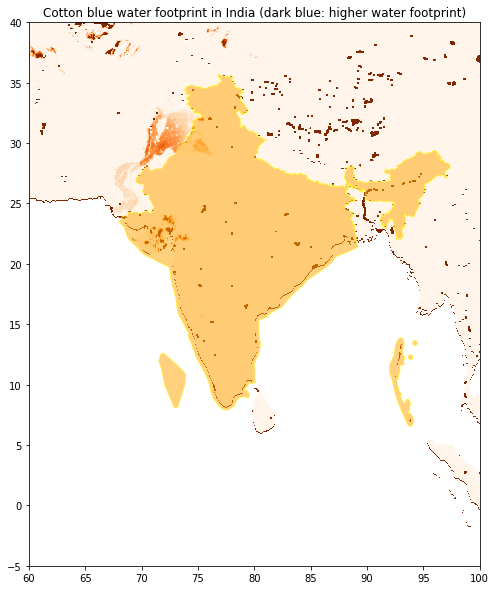

In [50]:
#check calculated risk map
with rio.open( '../../datasets/processed/water_risk_cotton_gdal_4326.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((-5,40))
    ax.set_xlim((60,100))
    rio.plot.show(dat, vmin=0, vmax=444, cmap='Oranges', ax=ax, transform=src.transform)
    gdf_india.plot(ax=ax, alpha=0.5, color='Orange', edgecolor='yellow')
    ax.set_title('Cotton blue water footprint in India (dark blue: higher water footprint)')

### Generate volume distribution map based on test data

#### Note:

This test location should be translated into h3 (similarly as the risk map). With this h3 we could perform joins directly with the tables. 

In order to simplify things, I'm translating the test polygon into hexgrid and joing attributes based on location with the risk map generated above. 

- generate the zonal statistics in h3 using just india and h3 data

In [7]:
## translate user data into h3
#lest select just one admin level 3 of india to reduce the computational time - this has been obtained from gadm
location_india = gpd.read_file('../../datasets/raw/located_lg_data_polygon_v2_india.shp')
location_india.head()

,fid,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,19.0,Cotton,None,745.0,India,None,None,None,Unknown,Low,"POLYGON ((68.11138 23.60145, 68.13528 23.64833..."
1,19.0,Cotton,None,745.0,India,None,None,None,Unknown,Low,"POLYGON ((71.56229 11.88792, 71.56235 11.89383..."
2,19.0,Cotton,None,745.0,India,None,None,None,Unknown,Low,"POLYGON ((71.67628 12.35248, 71.67633 12.35838..."
3,19.0,Cotton,None,745.0,India,None,None,None,Unknown,Low,"POLYGON ((71.81635 11.15321, 71.81641 11.15914..."
4,19.0,Cotton,None,745.0,India,None,None,None,Unknown,Low,"POLYGON ((72.05613 10.06355, 72.05618 10.06950..."


In [6]:
# This raster would be transform to h3 ideally and the calculations would be done joining indexes
water_risk_map = '../../datasets/processed/water_risk_cotton_gdal_4326.tif'

# faction harvest area for cotton needed for calculating the asignation factor
cotton_harvest_fraction = '../../datasets/raw/cotton_HarvestedAreaFraction.tif'


### Generate h3 for geom

In [16]:
# generate h3 for india file
def generate_h3_features(geometry, res):
    """
    Generate h3 for geometry
    
    Input
    ------
    geometry: shapely.polygon or shapely.multipolygon
    
    Output
    ------
    gdf with H3_hexes
    """
    # Create an empty dataframe to write data into
    h3_df = pd.DataFrame([],columns=['h3_id'])
    if geometry.geom_type == 'MultiPolygon':
        district_polygon = list(geometry)
        for polygon in district_polygon:
            poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
            poly_geojson = poly_geojson['features'][0]['geometry'] 
            h3_hexes = h3.polyfill_geojson(poly_geojson, res)
            for h3_hex in h3_hexes:
                coords = h3.h3_set_to_multi_polygon([h3_hex], geo_json=True)
                yield {
                    "type": "Feature",
                    "properties": {"hexid": h3_hex},
                    "geometry": {"type": "Polygon", "coordinates": coords[0]},
                }
    elif geometry.geom_type == 'Polygon':
        poly_geojson = gpd.GeoSeries(geometry).__geo_interface__
        poly_geojson = poly_geojson['features'][0]['geometry']
        h3_hexes = h3.polyfill_geojson(poly_geojson, res)
        for h3_hex in h3_hexes:
            coords = h3.h3_set_to_multi_polygon([h3_hex], geo_json=True)
            yield {
                "type": "Feature",
                "properties": {"hexid": h3_hex},
                "geometry": {"type": "Polygon", "coordinates": coords[0]},
            }
    else:
        print('Shape is not a polygon or multypolygon.')


In [35]:
#time spend in generating the features in h3 for the basins test in resolution 1
start_time = time.time()
h3_india_res6 = [generate_h3_features(poly, 6) for poly in location_india['geometry']]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0001957416534423828 seconds ---


In [18]:
## zonal statistics with harvest area protion to calculate distribution 
#summary statistics world main basins
start_time = time.time()

summ_stats_h3_india = [gen_zonal_stats(
    generator,
    cotton_harvest_fraction,
    stats="median",
    prefix="m_",
    geojson_out=True,
    all_touched=True
    ) for generator in h3_india_res6]
    
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 9.799003601074219e-05 seconds ---


In [19]:
for generator in summ_stats_h3_india:
    for feature in generator:
        print(feature)
        break

{'type': 'Feature', 'properties': {'hexid': '86602285fffffff', 'm_median': 0.0}, 'geometry': {'type': 'Polygon', 'coordinates': [[(76.5523234113541, 8.945849997724665), (76.52379927794678, 8.96389625490124), (76.49483146922847, 8.947210096677049), (76.49438137210103, 8.91248711372419), (76.52289234500407, 8.89443833201857), (76.55186657348857, 8.911115058205468), (76.5523234113541, 8.945849997724665)]]}}
{'type': 'Feature', 'properties': {'hexid': '86600b5b7ffffff', 'm_median': None}, 'geometry': {'type': 'Polygon', 'coordinates': [[(71.83306101913588, 11.905981613227686), (71.80579020887748, 11.922508840415505), (71.7786165945592, 11.905382737600407), (71.77870550829061, 11.871738271466656), (71.80596196285462, 11.855205999246625), (71.83314385681078, 11.872323237057525), (71.83306101913588, 11.905981613227686)]]}}
{'type': 'Feature', 'properties': {'hexid': '8660e48f7ffffff', 'm_median': None}, 'geometry': {'type': 'Polygon', 'coordinates': [[(71.77754807078928, 12.309049055442372), 

In [21]:
## generate datafram
#generate a dataframe with the elements
start_time = time.time()
h3_gdf_india_res6 = pd.DataFrame([],columns=['h3_id', 'area_fraction'])
for generator in summ_stats_h3_india:
    for feature in generator:
        h3_gdf_india_res6.loc[len(h3_gdf_india_res6)]=[
            feature['properties']['hexid'],
            feature['properties']['m_median']]
print("--- %s seconds ---" % (time.time() - start_time))

--- 803.3259239196777 seconds ---


In [23]:
h3_gdf_india_res6['Volume'] = 750

In [29]:
#remove nans
h3_gdf_india_res6 = h3_gdf_india_res6.dropna()

In [31]:
h3_gdf_india_res6['total_af'] = sum(list(h3_gdf_india_res6['area_fraction']))
h3_gdf_india_res6.head()

<ipython-input-31-6f6cfd5ee2bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h3_gdf_india_res6['total_af'] = sum(list(h3_gdf_india_res6['area_fraction']))


,h3_id,area_fraction,Volume,total_af
0,8660a3437ffffff,9.612672e-03,750,2043.238569
1,863d8835fffffff,2.306188e-07,750,2043.238569
2,863d84b47ffffff,3.100510e-04,750,2043.238569
3,863c528e7ffffff,0.000000e+00,750,2043.238569
4,8660aba4fffffff,0.000000e+00,750,2043.238569


In [34]:
## calculate asignation fraction as area fraction / total_af
for i, row in h3_gdf_india_res6.iterrows():
    assignation_factor = row['area_fraction']/ row['total_af']
    distributed_volume = row['Volume']*assignation_factor
    h3_gdf_india_res6.loc[i, 'assignation_factor'] = assignation_factor
    h3_gdf_india_res6.loc[i, 'distributed_vol'] = distributed_volume

h3_gdf_india_res6.head()

,h3_id,area_fraction,Volume,total_af,assignation_factor,distributed_vol
0,8660a3437ffffff,9.612672e-03,750,2043.238569,4.704625e-06,3.528469e-03
1,863d8835fffffff,2.306188e-07,750,2043.238569,1.128692e-10,8.465192e-08
2,863d84b47ffffff,3.100510e-04,750,2043.238569,1.517449e-07,1.138087e-04
3,863c528e7ffffff,0.000000e+00,750,2043.238569,0.000000e+00,0.000000e+00
4,8660aba4fffffff,0.000000e+00,750,2043.238569,0.000000e+00,0.000000e+00


### Calculate water impact

Water imapct would be calculated as shown before but retrieved in h3


In [36]:
## zonal statistics with harvest area protion to calculate distribution 
#summary statistics world main basins
start_time = time.time()

summ_stats_h3_india_wr_cotton = [gen_zonal_stats(
    generator,
    water_risk_map ,
    stats="median",
    prefix="m_",
    geojson_out=True,
    all_touched=True
    ) for generator in h3_india_res6]
    
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00011324882507324219 seconds ---


In [37]:
## get geodataframe with water risk

start_time = time.time()
h3_gdf_india_res6_wr = pd.DataFrame([],columns=['h3_id', 'water_Risk'])
for generator in summ_stats_h3_india_wr_cotton:
    for feature in generator:
        h3_gdf_india_res6_wr.loc[len(h3_gdf_india_res6_wr)]=[
            feature['properties']['hexid'],
            feature['properties']['m_median']]
print("--- %s seconds ---" % (time.time() - start_time))

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


--- 957.7292029857635 seconds ---


In [38]:
h3_gdf_india_res6_wr.head()

,h3_id,water_Risk
0,86602285fffffff,inf
1,863db4607ffffff,0.110634
2,863ca064fffffff,0.000000
3,8642e9117ffffff,0.000000
4,863da306fffffff,0.000000


### Calculate impact metric

In [40]:
h3_gdf_india_res6.head()

,h3_id,area_fraction,Volume,total_af,assignation_factor,distributed_vol
0,8660a3437ffffff,9.612672e-03,750,2043.238569,4.704625e-06,3.528469e-03
1,863d8835fffffff,2.306188e-07,750,2043.238569,1.128692e-10,8.465192e-08
2,863d84b47ffffff,3.100510e-04,750,2043.238569,1.517449e-07,1.138087e-04
3,863c528e7ffffff,0.000000e+00,750,2043.238569,0.000000e+00,0.000000e+00
4,8660aba4fffffff,0.000000e+00,750,2043.238569,0.000000e+00,0.000000e+00


In [41]:
h3_gdf_india_res6_wr.head()

,h3_id,water_Risk
0,86602285fffffff,inf
1,863db4607ffffff,0.110634
2,863ca064fffffff,0.000000
3,8642e9117ffffff,0.000000
4,863da306fffffff,0.000000


In [53]:
list(h3_gdf_india_res6_wr[h3_gdf_india_res6_wr['h3_id']=='8660a3437ffffff']['water_Risk'])[0]

0.0

In [54]:
##join dataframes
start_time = time.time()
for i, row in h3_gdf_india_res6.iterrows():
    
    h3_id = row['h3_id']
    water_risk = list(h3_gdf_india_res6_wr[h3_gdf_india_res6_wr['h3_id']==f'{h3_id}']['water_Risk'])[0]
    h3_gdf_india_res6.loc[i, 'water_risk'] = water_risk
print("--- %s seconds ---" % (time.time() - start_time))

--- 1477.95259308815 seconds ---


In [55]:
h3_gdf_india_res6.head()

,h3_id,area_fraction,Volume,total_af,assignation_factor,distributed_vol,water_risk
0,8660a3437ffffff,9.612672e-03,750,2043.238569,4.704625e-06,3.528469e-03,0.0
1,863d8835fffffff,2.306188e-07,750,2043.238569,1.128692e-10,8.465192e-08,0.0
2,863d84b47ffffff,3.100510e-04,750,2043.238569,1.517449e-07,1.138087e-04,0.0
3,863c528e7ffffff,0.000000e+00,750,2043.238569,0.000000e+00,0.000000e+00,0.0
4,8660aba4fffffff,0.000000e+00,750,2043.238569,0.000000e+00,0.000000e+00,0.0


In [ ]:
## calculate asignation fraction as area fraction / total_af
for i, row in h3_gdf_india_res6.iterrows():
    total_impact = row['distributed_vol'] * row['water_risk']

h3_gdf_india_res6.head()

## Aqueduct BWS

In [49]:
bws = gpd.read_file("../raw_data/aqueduct3_bws_trunc.shp")
bws.head()

,fid,DN,geometry
0,1.0,1,"POLYGON ((-39.58333 83.41667, -39.16667 83.416..."
1,2.0,0,"POLYGON ((-38.00000 83.41667, -37.83333 83.416..."
2,3.0,1,"POLYGON ((-40.75000 83.33333, -39.83333 83.333..."
3,4.0,0,"POLYGON ((-43.83333 83.16667, -43.75000 83.166..."
4,5.0,1,"POLYGON ((-39.00000 83.16667, -38.75000 83.166..."


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


Text(0.5, 1.0, 'Aqueduct BWS in India (dark red: higher bws)')

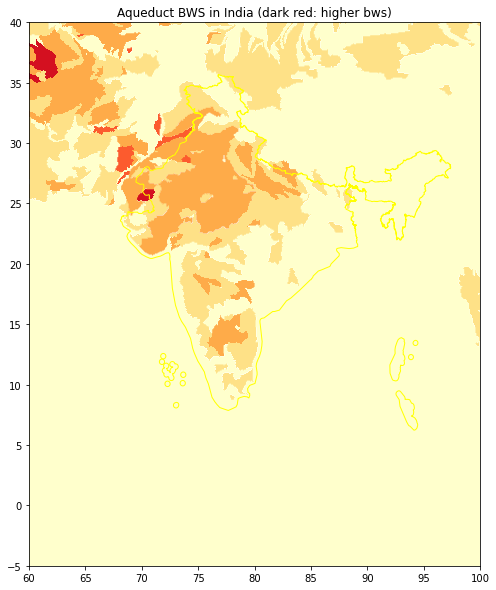

In [52]:
#import aqueduct bws 

fig, ax = plt.subplots(figsize=[15,10])
ax.set_ylim((-5,40))
ax.set_xlim((60,100))
bws.plot(ax=ax, column='DN', cmap='YlOrRd', vmin=0, vmax=5)
gdf_india.plot(ax=ax, color='', edgecolor='yellow')
ax.set_title('Aqueduct BWS in India (dark red: higher bws)')